<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/fonttools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loads TrueType fonts using https://pypi.org/project/TTFQuery/ (Py3 version from https://github.com/mindw/ttfquery), and triangulates them using https://rufat.be/triangle/ library, and Shapely https://shapely.readthedocs.io/en/stable/manual.html for geometry.
Builds a Triangle Stack, a list of points with implicit rules for building a triangled font glyph (character) from the points as follows:

1. Each element consists of an optional point and an optional triangle (represented by 2 bools).
2. If present the point (x, y floats) is added to a stack.
3. If present the triangle is represented by the latest point and two relative offsets in the stack (2 ints)

*TODO*
Import from Google Fonts https://developers.google.com/fonts/docs/developer_api or https://github.com/google/fonts/archive/master.zip


# Imports

In [10]:
#@title Imports
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
#from enum import Enum, IntEnum
from copy import copy
import math
import os
import collections
import glob 
import copy
#import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
print("np", np.__version__)
print("tf", tf.__version__)
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display

#!pip install triangle
import triangle as tr
print("tr", tr.__version__)

#!pip install fonttools
#from fontTools.ttLib import TTFont

# should be:
#!pip install ttfquery
# or 
#!conda install -c mwcraig ttfquery
# but actually had to:
#git clone git@github.com:mindw/ttfquery.git
#cd ttfquery
#python setup.py install

import ttfquery.describe
import ttfquery.glyph
import ttfquery.findsystem
print("ttfquery", ttfquery.__version__)

#!pip install shapely
# or on windows:
#!conda config --add channels conda-forge
#!conda install shapely
import shapely.ops
import shapely.geometry
import shapely.affinity
print("shapely", shapely.__version__)

#!pip install descartes
import descartes


#Mar2019:
# np 1.14.2
# tf 1.10.0
# tr 20190115.1
# ttfquery 1.0.5
# shapely 1.6.4.post2

C:\Users\terry\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


np 1.16.2
tf 1.13.1
tr 20190115.1
ttfquery 1.0.5
shapely 1.6.4.post2


# Setup

In [11]:
def readFonts(files: [str], glyphs: str): # type: List(List[MultiPolygon))
  print('loading {} files'.format(len(files)))
  tolerance = 0.001
  fonts = []
  for fontfile in files:
    try:
      print(fontfile)
      font = ttfquery.describe.openFont(fontfile)
      multipolys = []
      for glyph in glyphs:
        g = ttfquery.glyph.Glyph(glyph)
        g.compile(font, steps=2)
        contours = [shapely.geometry.LinearRing(contour) for contour in g.outlines]
        #contours = [shapely.geometry.LinearRing(contour) for contourflags in g.calculateContours(font) for contour, flag in contourflags]
        size = 1.0
        contours = [shapely.affinity.scale(contour, size/g.height, size/g.height, origin=(0,0.1))
                    for contour in contours]
        polys = []
        holes = []
        # Find contours inside other contours and make them holes
        for contour in contours:
          for i, poly in enumerate(polys):
            if shapely.geometry.Polygon(contour).contains(shapely.geometry.Polygon(poly)):
              #replace
              polys[i] = contour
              holes[i].append(poly)
              break
            elif shapely.geometry.Polygon(poly).contains(shapely.geometry.Polygon(contour)):
              holes[i].append(contour)
              break
          else:
            polys.append(contour)
            holes.append([])
        multipolys.append(shapely.geometry.MultiPolygon(
            [shapely.geometry.Polygon(poly, hole).simplify(tolerance) for poly, hole in zip(polys, holes)]))
      fonts.append(multipolys)
    except Exception as e:
      print(e)
  print('loaded {} files'.format(len(fonts)))
  return fonts

In [12]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
max_outline_points = 200
#files = glob.glob('deeper/fonts/*.ttf')
#files = list(ttfquery.findsystem.findFonts())
google_font_dir = r'C:\Users\terry\Downloads\fonts-master\apache'
#google_font_dir = r'C:\Users\terry\Downloads\fonts-master\ofl'
dirs = [os.path.join(google_font_dir, dir) for dir in os.listdir(google_font_dir)]
files = []
for dir in dirs:
  if 'sans' in open(os.path.join(dir, 'DESCRIPTION.en_us.html')).read():
    files += [os.path.join(dir, f) for f in os.listdir(dir) if 'ttf' in f] 
np.random.seed(2)
#np.random.shuffle(files)
#files = files[0:5]
print(files)
fonts = readFonts(files, glyphs)
#print(fonts[0][0])


setup...
['C:\\Users\\terry\\Downloads\\fonts-master\\apache\\aclonica\\Aclonica-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Bold.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-BoldItalic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Italic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cherrycreamsoda\\CherryCreamSoda-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Bold.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-BoldItalic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Italic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\luckiestguy\\LuckiestGuy-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\opensans\\OpenSan

Expanded outline doesn't have proper format! Should always have either [on, off, on] or [on, on] as the first items in the outline
C:\Users\terry\Downloads\fonts-master\apache\syncopate\Syncopate-Bold.ttf
C:\Users\terry\Downloads\fonts-master\apache\syncopate\Syncopate-Regular.ttf
loaded 28 files


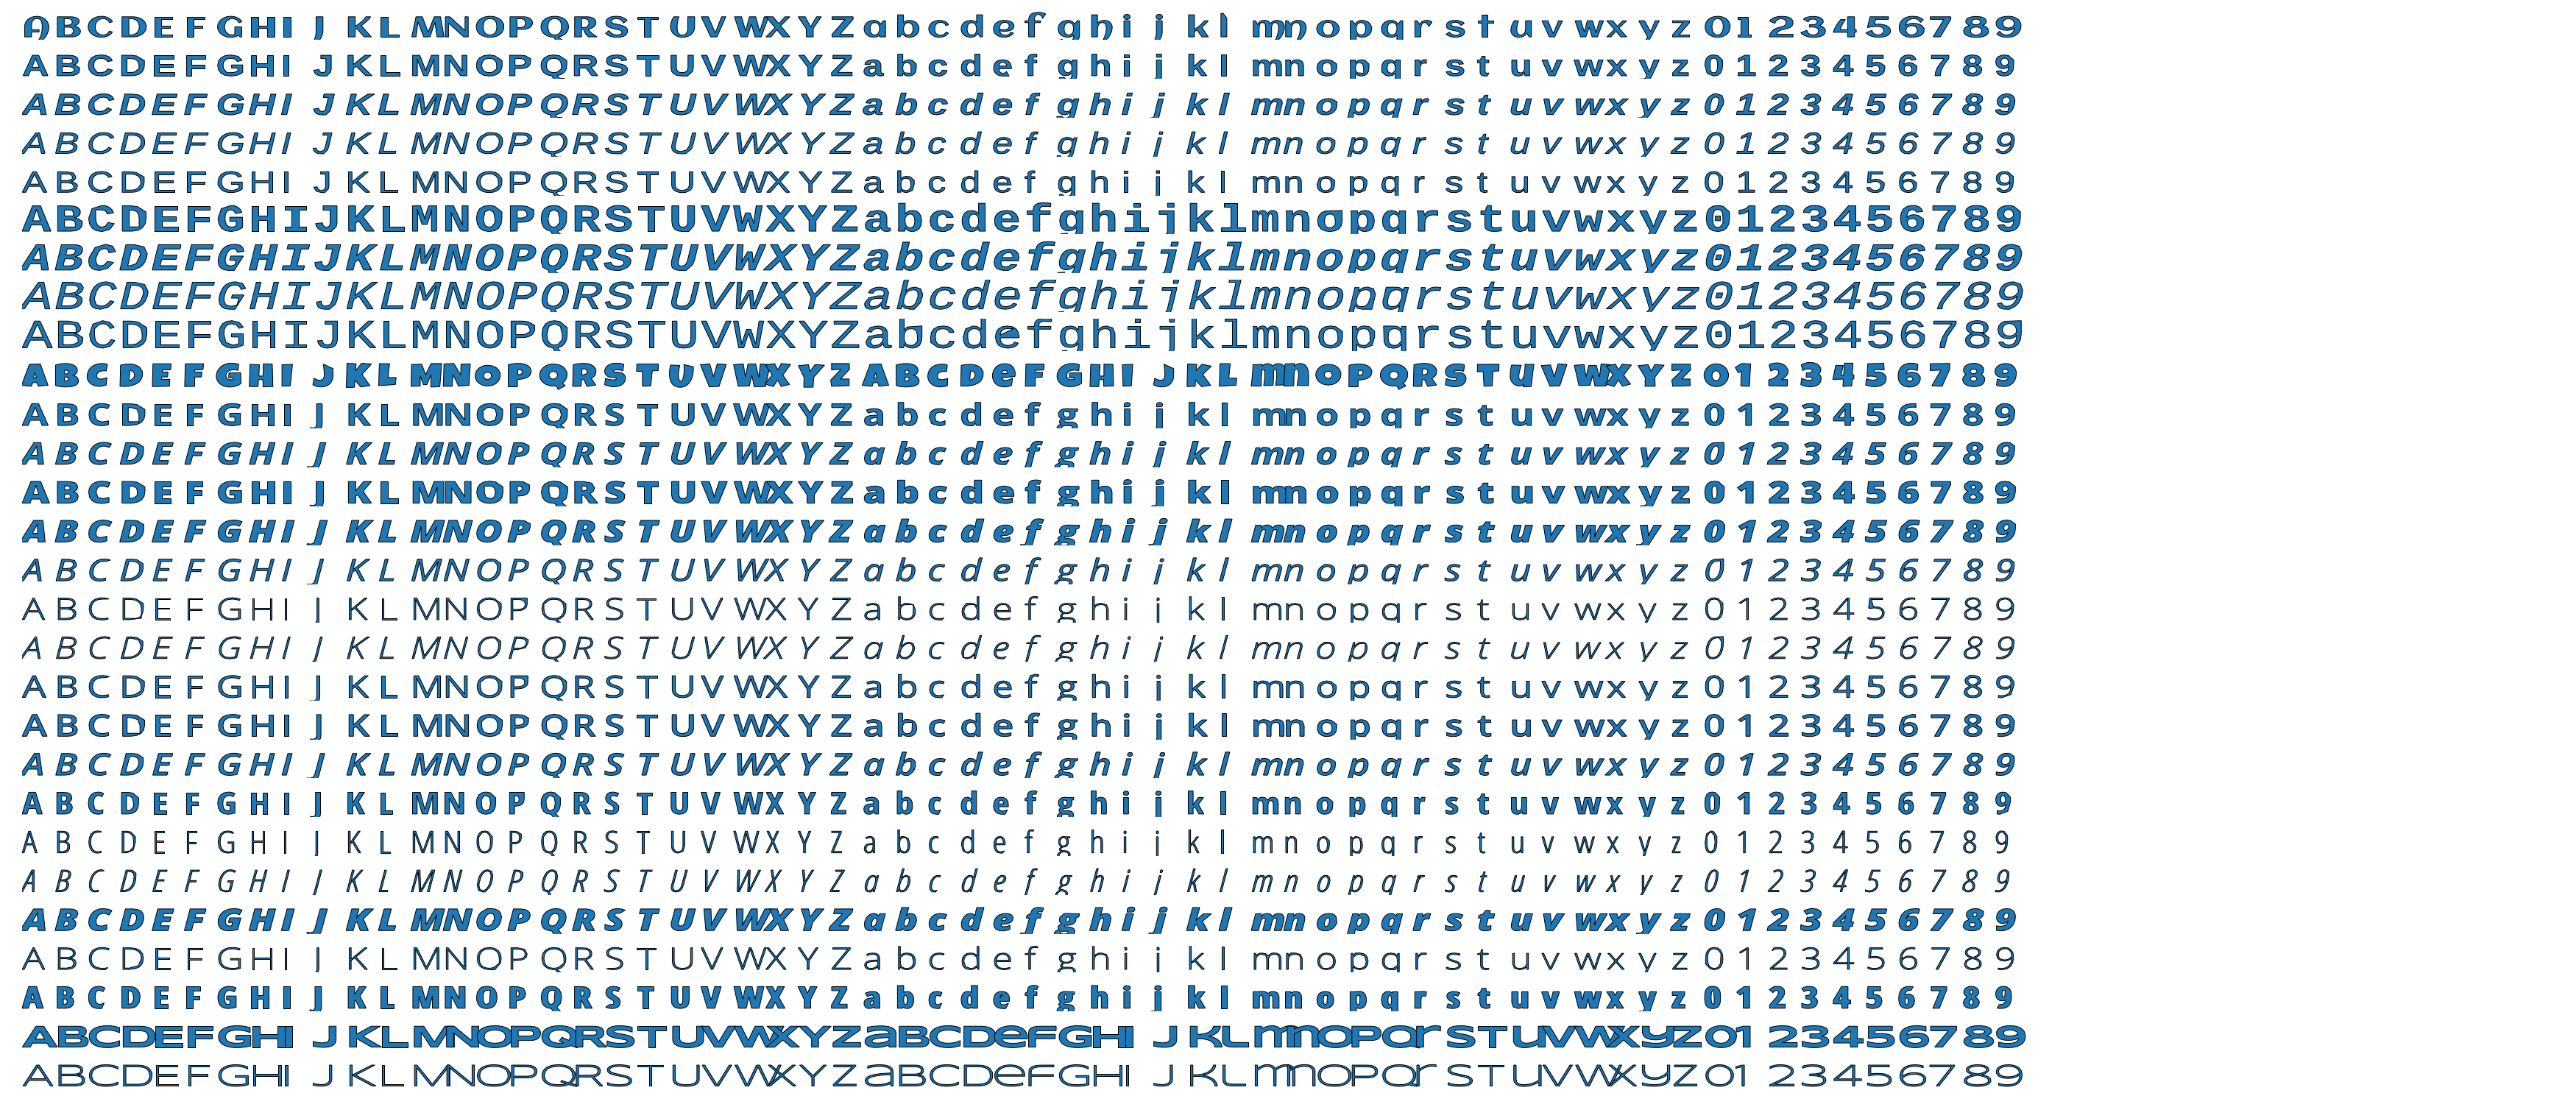

In [13]:
def drawMultiPolygons(polygons):
  fonts = len(polygons)
  glyphs = max([len(polygon) for polygon in polygons])
  plt.figure(figsize=(glyphs,fonts))
  for f in range(fonts):
    ax = plt.subplot(fonts+1, 1, 1+f)
    ax.set_xlim(0, glyphs+1)
    ax.set_axis_off()
    for glyph in range(glyphs):
      ax.add_patch(descartes.PolygonPatch(
          shapely.affinity.translate(polygons[f][glyph], glyph*0.8)
      ))
  plt.show()

drawMultiPolygons(fonts)


In [14]:
# Shapely triangulation doesn't handle holes, so use tr module instead
#triangles = shapely.ops.triangulate(fonts[0][0])

def add_poly(coords, vertices, segments):
  start = len(vertices)
  vertices += coords[:-1]
  segments += [(i, i+1) for i in range(start, start+len(coords)-2)]
  segments.append((start+len(coords)-2, start))

def get_T(glyph):
  vertices = []
  segments = []
  holes = []
  for poly in glyph:
    add_poly(poly.exterior.coords, vertices, segments)
    for interior in poly.interiors:
      add_poly(interior.coords, vertices, segments)
      holes.append(shapely.geometry.Polygon(interior).representative_point().coords[:])
  T = {
    'vertices': np.array(vertices),
    'segments': np.array(segments),
  }
  if holes:
    T['holes'] = np.array(holes).reshape((-1,2))
  return T


In [15]:
#@ Populate nptris
nptris = np.empty((len(fonts), len(glyphs)), dtype=dict)
for f in range(len(fonts)):
  for g in range(len(glyphs)):
    T = get_T(fonts[f][g])
    opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
    #opts += 'q20' # conforming constrained Delaunay triangulation of a PSLG 
    #opts += 'D' # conforming Delaunay triangulation 
    nptris[f,g] = tr.triangulate(T, opts)
    #print(f, g, len(vertices), nptris[f,g]['triangles'].shape)

counts = [(glyphs[g],
           nptris[f,g]['vertices'].size,
           nptris[f,g]['triangles'].size,
           np.bincount(nptris[f,g]['triangles'].flatten()).max(), # vertex used by max number of triangles
           (np.bincount(nptris[f,g]['triangles'].flatten())==np.bincount(nptris[f,g]['triangles'].flatten()).max()).sum(), # vertices sharing max triangles
          )
          for f in range(len(fonts)) for g in range(len(glyphs))]
print(counts)
print("max values: ", [max(v[i] for v in counts) for i in range(len(counts[0]))])
print("max tris: ", counts[max((c[2],i) for i, c in enumerate(counts))[1]])
#print([c for c in counts if c[3]>6])
#print([c for c in counts if c[4]>8])
#plt.figure(figsize=(50,2))
# tr.plot(ax,
#         vertices=[p for poly in triangles for p in poly.exterior.coords],
#         triangles=[(i, i+1, i+2) for i in range(len(triangles))]
#        )
# for i,poly in enumerate(triangles):
#   ax = plt.subplot(1, len(triangles), 1+i)
#   ax.add_patch(descartes.PolygonPatch(poly))
#plt.show()

[('A', 132, 192, 4, 11), ('B', 142, 219, 9, 1), ('C', 154, 225, 4, 10), ('D', 88, 132, 5, 2), ('E', 24, 30, 5, 1), ('F', 20, 24, 5, 1), ('G', 146, 213, 5, 1), ('H', 24, 30, 5, 1), ('I', 8, 6, 2, 2), ('J', 40, 54, 3, 16), ('K', 36, 48, 5, 2), ('L', 12, 12, 4, 1), ('M', 26, 33, 5, 3), ('N', 20, 24, 5, 2), ('O', 150, 225, 4, 13), ('P', 78, 117, 6, 1), ('Q', 182, 273, 7, 1), ('R', 96, 144, 6, 1), ('S', 212, 312, 5, 1), ('T', 16, 18, 4, 2), ('U', 114, 165, 4, 9), ('V', 14, 15, 5, 1), ('W', 26, 33, 5, 3), ('X', 24, 30, 6, 2), ('Y', 18, 21, 5, 1), ('Z', 20, 24, 5, 2), ('a', 144, 216, 7, 2), ('b', 144, 216, 8, 1), ('c', 132, 192, 4, 8), ('d', 142, 213, 9, 1), ('e', 192, 288, 5, 2), ('f', 78, 111, 5, 2), ('g', 206, 309, 8, 1), ('h', 100, 144, 8, 1), ('i', 70, 93, 7, 2), ('j', 102, 141, 7, 2), ('k', 44, 60, 6, 1), ('l', 10, 9, 3, 1), ('m', 160, 234, 8, 1), ('n', 108, 156, 7, 1), ('o', 172, 258, 4, 12), ('p', 146, 219, 9, 1), ('q', 144, 216, 10, 1), ('r', 72, 102, 6, 1), ('s', 192, 282, 5, 3), ('

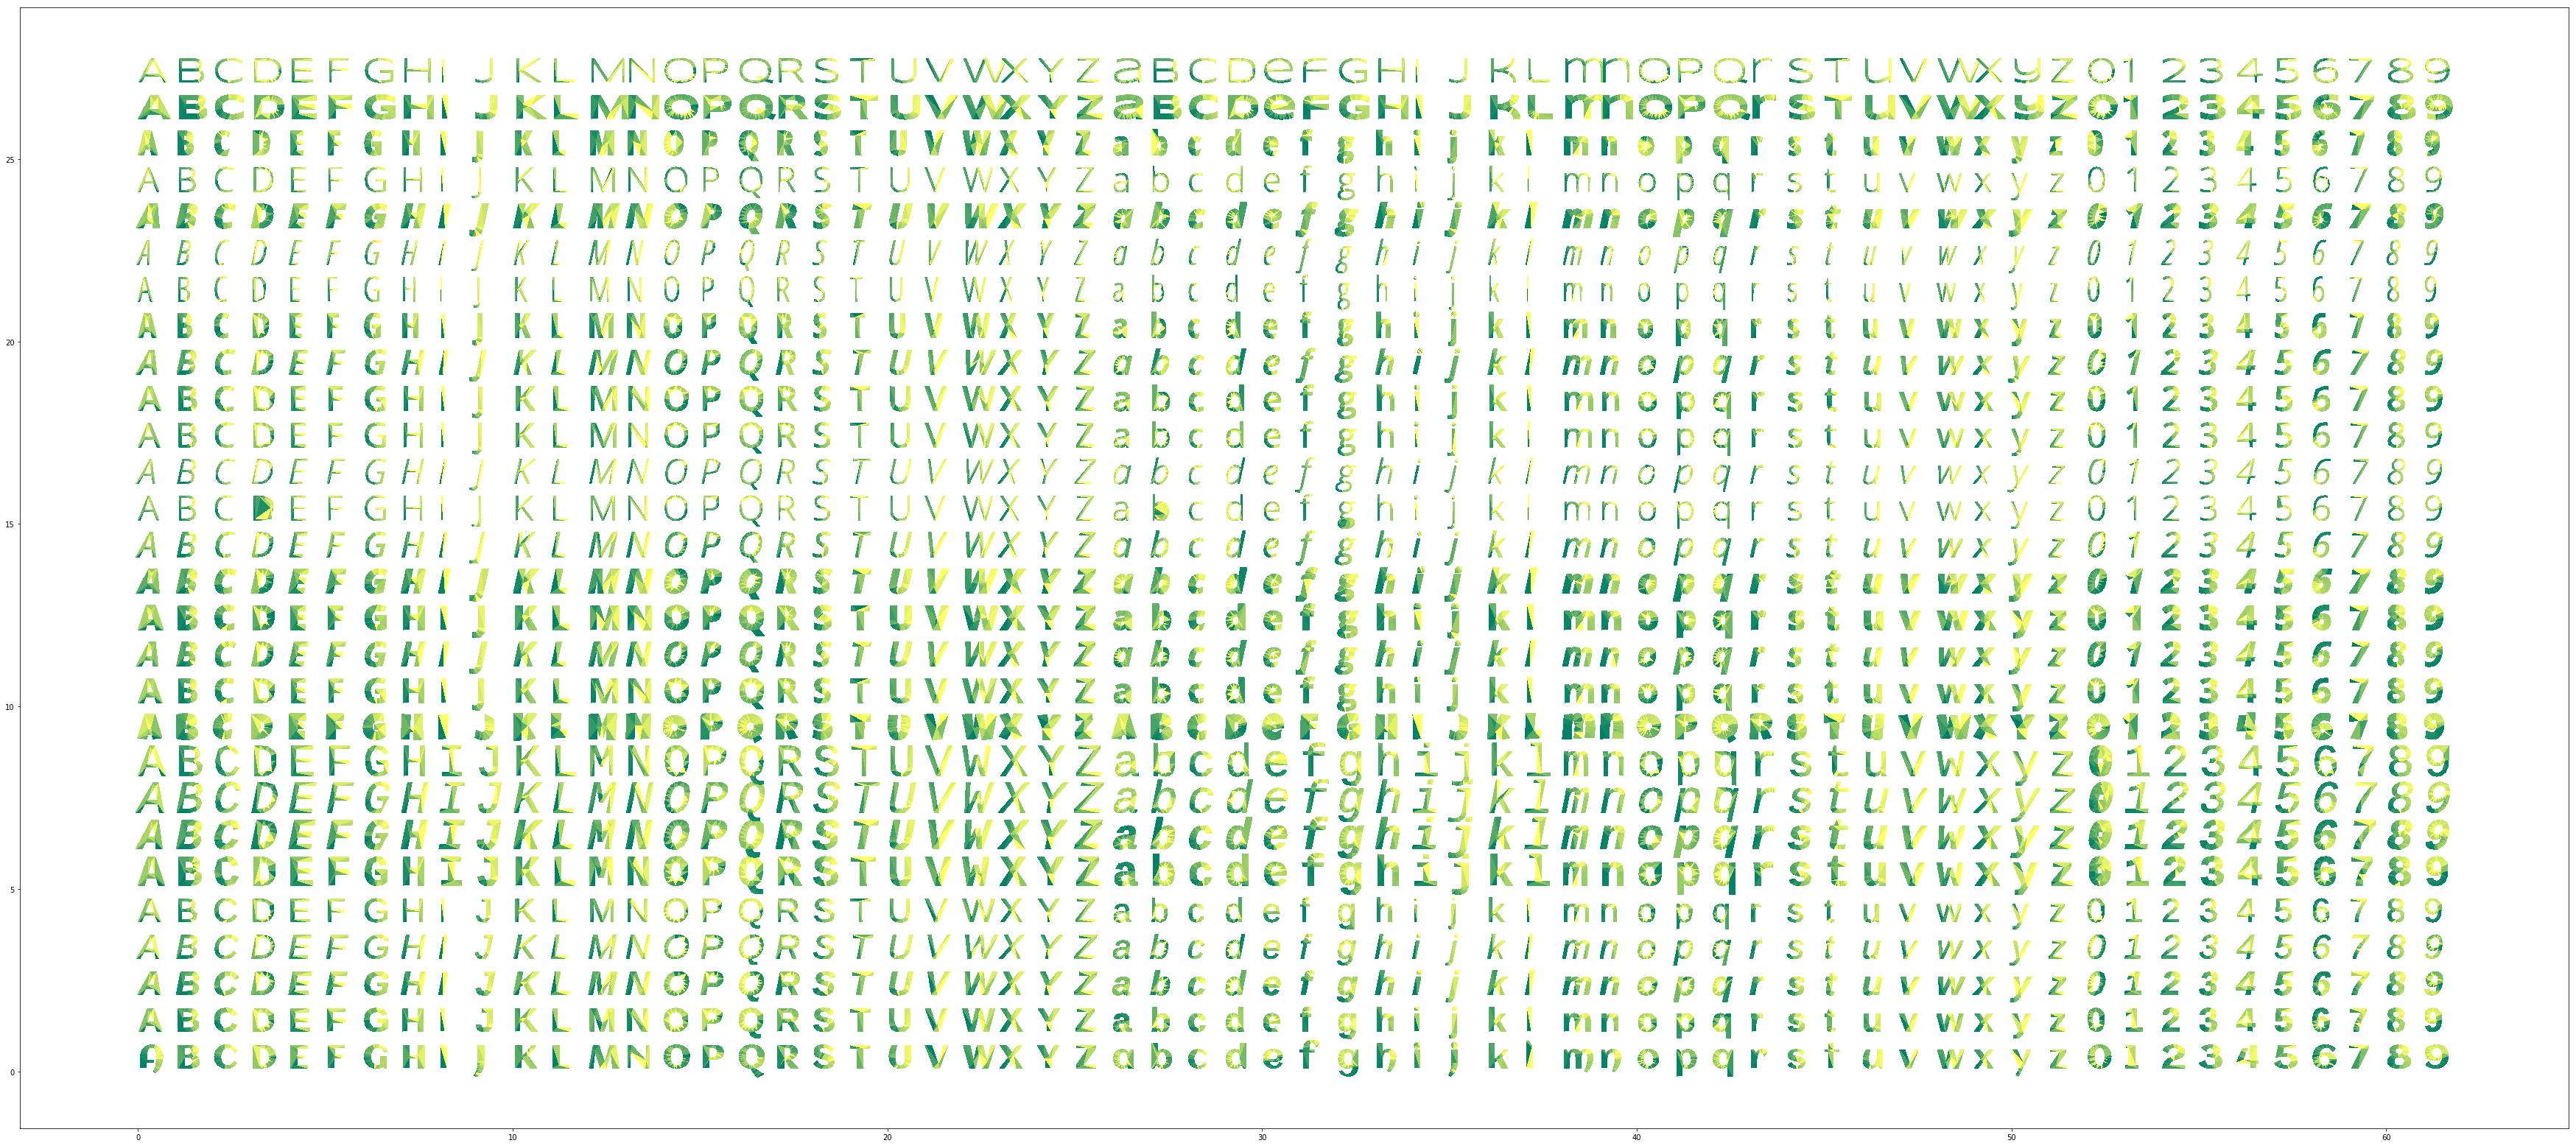

In [16]:
def drawTris(nptris):
  shape = nptris.shape
  plt.figure(figsize=(shape[1],shape[0]))
  ax = plt.plot()
  for f in range(shape[0]):
    for g in range(shape[1]):
      if nptris[f,g]:
        vertices = np.array(nptris[f,g]["vertices"]) + np.array([g,f])
        triangles = np.array(nptris[f,g]["triangles"])
        tri = matplotlib.tri.Triangulation(vertices[:,0], vertices[:,1], triangles)
        plt.tripcolor(tri, range(len(triangles)), cmap=plt.summer())
  plt.show()

drawTris(nptris)


# Build and test TriangleStack

('eight', 122, 189, 5, 5)
189


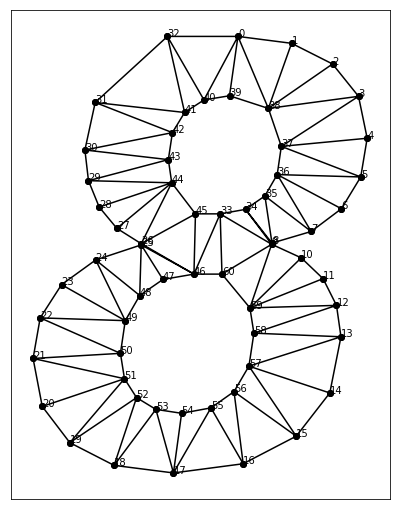

In [17]:
font,glyph_num=2,glyphs.index('eight')
glyph = nptris[font,glyph_num]
#print(nptris[f,g]['triangles'][0:10])
print(counts[font*len(glyphs)+glyph_num])
print(np.bincount(glyph['triangles'].flatten()).sum())
plt.figure(figsize=(7,9))
ax = plt.subplot(111)
tr.plot(ax, vertices=glyph['vertices'], triangles=glyph['triangles'], labels=1)
plt.show()

In [38]:
import importlib
import TriangleStack as ts
importlib.reload(ts)

tri_stack = ts.TriangleStack.build_stack(glyph, debug=False)
print("Stack: ", tri_stack._elements)
triangles = tri_stack.get_triangles(debug=False)



Stack:  [Element(vertex=array([0.47, 0.48]), triangle_offsets=None), Element(vertex=array([0.43, 0.45]), triangle_offsets=None), Element(vertex=array([0.38, 0.54]), triangle_offsets=[0, 0]), Element(vertex=array([0.36, 0.5 ]), triangle_offsets=[0, 0]), Element(vertex=array([0.37, 0.43]), triangle_offsets=[0, 1]), Element(vertex=array([0.33, 0.48]), triangle_offsets=[0, 0]), Element(vertex=array([0.37, 0.43]), triangle_offsets=[0, 0]), Element(vertex=array([0.29, 0.48]), triangle_offsets=[0, 0]), Element(vertex=array([0.29, 0.39]), triangle_offsets=[0, 0]), Element(vertex=array([0.25, 0.39]), triangle_offsets=[0, 0]), Element(vertex=array([0.25, 0.48]), triangle_offsets=[0, 1]), Element(vertex=array([0.17, 0.43]), triangle_offsets=[0, 0]), Element(vertex=array([0.22, 0.52]), triangle_offsets=[0, 0]), Element(vertex=array([0.14, 0.46]), triangle_offsets=[0, 0]), Element(vertex=array([0.11, 0.49]), triangle_offsets=[0, 0]), Element(vertex=array([0.09, 0.53]), triangle_offsets=[0, 1]), Ele

TypeError: 'NoneType' object is not subscriptable

In [46]:
for i in range(len(tri_stack.elements)):
    e1 = ts.TriangleStack.from_array(tri_stack.array).elements[i]
    e2 = tri_stack.elements[i]
    assert (e1.vertex is None) == (e2.vertex is None)
    if e1.vertex:
        assert abs(e1.vertex[0] - e2.vertex[0])<0.0001
        assert abs(e1.vertex[1] - e2.vertex[1])<0.0001
    assert (e1.triangle_offsets is None) == (e2.triangle_offsets is None)
    assert e1.triangle_offsets == e2.triangle_offsets


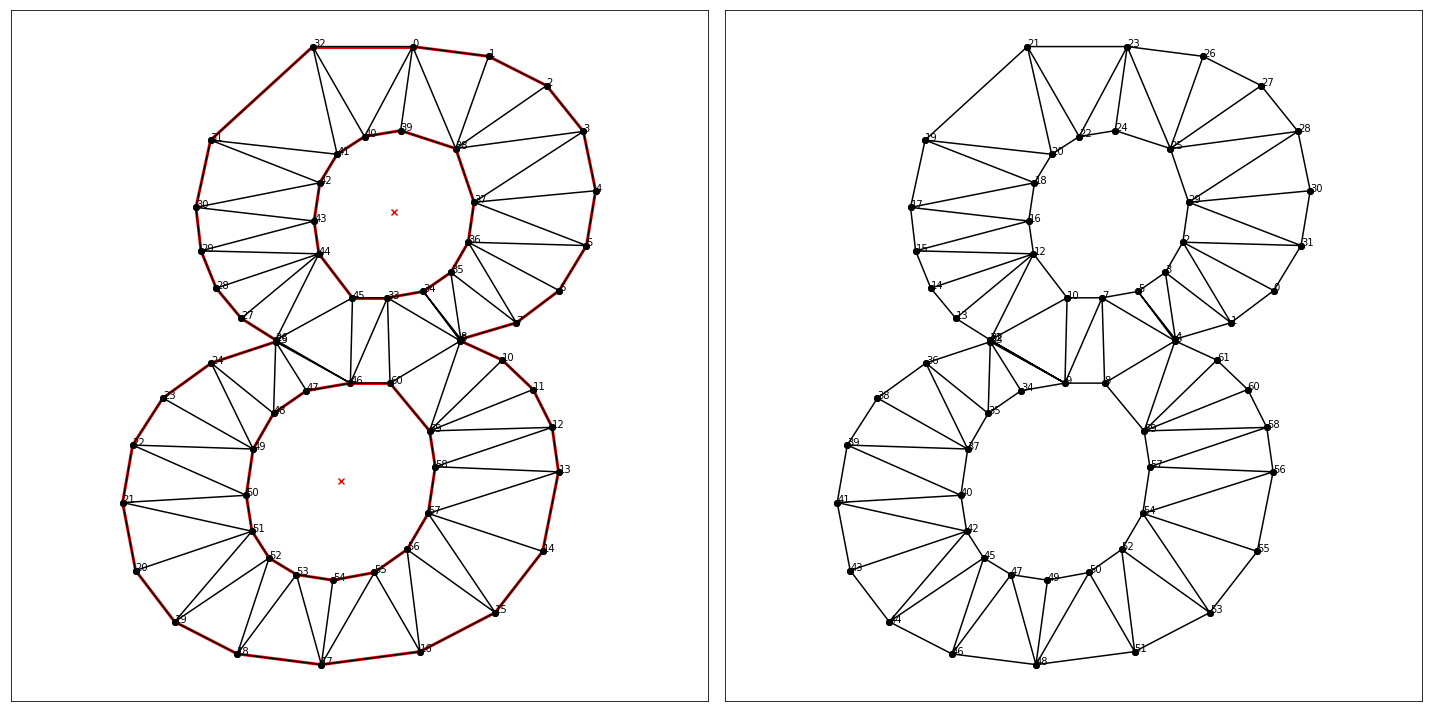

In [47]:
glyph['labels']=1
triangles['labels']=1
tr.compare(plt, glyph, triangles, figsize=(20,10))
plt.show()

# Write TFRecord

In [50]:
# Write to collection

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _string_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))
def _float_array_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

#drive.mount('/content/gdrive')
#with open('/content/gdrive/My Drive/fonts8.tfrecords', 'w') as f:
#  f.write('Hello Google Drive!')

filename = r'C:\src\notebooks\deeper\fonts\test.tfrecords'
print('Writing', filename)
max_elements = 0
with tf.io.TFRecordWriter(filename) as writer:
  for f in range(len(fonts)):
    print("font: ", f, files[f])
    for g in range(len(glyphs)):
      T = get_T(fonts[f][g])
      opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
      #opts += 'q20' # conforming constrained Delaunay triangulation of a PSLG 
      #opts += 'D' # conforming Delaunay triangulation 
      nptri = tr.triangulate(T, opts)
      tri_stack = ts.TriangleStack.build_stack(nptri)
      print("Stack elements: ", glyphs[g], len(tri_stack.elements))
      max_elements = max(max_elements, len(tri_stack.elements))

      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'glyph_num': _int64_feature(g),
            'glyph': _string_feature(glyphs[g]),
            'font_num': _int64_feature(f),
            'font': _string_feature(os.path.basename(files[f])),
            'tri_stack': _float_array_feature(tri_stack.array.flatten()),
          }))
      writer.write(example.SerializeToString())
print(max_elements)

Writing C:\src\notebooks\deeper\fonts\test.tfrecords
font:  0 C:\Users\terry\Downloads\fonts-master\apache\aclonica\Aclonica-Regular.ttf
Stack elements:  A 67
Stack elements:  B 76
Stack elements:  C 77
Stack elements:  D 46
Stack elements:  E 13
Stack elements:  F 12
Stack elements:  G 75
Stack elements:  H 13
Stack elements:  I 4
Stack elements:  J 20
Stack elements:  K 20
Stack elements:  L 6
Stack elements:  M 13
Stack elements:  N 10
Stack elements:  O 77
Stack elements:  P 41
Stack elements:  Q 93
Stack elements:  R 52
Stack elements:  S 106
Stack elements:  T 9
Stack elements:  U 57
Stack elements:  V 7
Stack elements:  W 13
Stack elements:  X 13
Stack elements:  Y 10
Stack elements:  Z 10
Stack elements:  a 75
Stack elements:  b 75
Stack elements:  c 66
Stack elements:  d 74
Stack elements:  e 98
Stack elements:  f 41
Stack elements:  g 106
Stack elements:  h 51
Stack elements:  i 43
Stack elements:  j 60
Stack elements:  k 24
Stack elements:  l 5
Stack elements:  m 83
Stack el

Stack elements:  m 49
Stack elements:  n 27
Stack elements:  o 30
Stack elements:  p 46
Stack elements:  q 42
Stack elements:  r 25
Stack elements:  s 53
Stack elements:  t 33
Stack elements:  u 27
Stack elements:  v 10
Stack elements:  w 22
Stack elements:  x 13
Stack elements:  y 23
Stack elements:  z 10
Stack elements:  zero 65
Stack elements:  one 18
Stack elements:  two 38
Stack elements:  three 54
Stack elements:  four 21
Stack elements:  five 36
Stack elements:  six 48
Stack elements:  seven 13
Stack elements:  eight 59
Stack elements:  nine 47
font:  6 C:\Users\terry\Downloads\fonts-master\apache\cousine\Cousine-Bold.ttf
Stack elements:  A 15
Stack elements:  B 47
Stack elements:  C 27
Stack elements:  D 24
Stack elements:  E 14
Stack elements:  F 11
Stack elements:  G 37
Stack elements:  H 14
Stack elements:  I 14
Stack elements:  J 22
Stack elements:  K 14
Stack elements:  L 6
Stack elements:  M 24
Stack elements:  N 14
Stack elements:  O 40
Stack elements:  P 28
Stack elemen

KeyboardInterrupt: 

<dtype: 'string'>
()
font (20,)


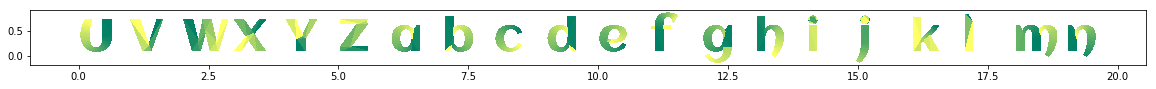

font_num (20,)


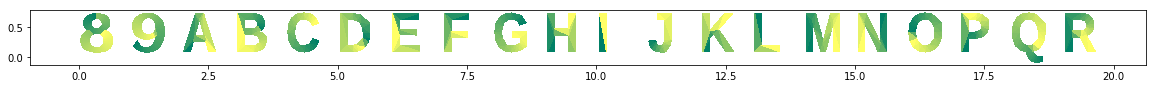

glyph (20,)


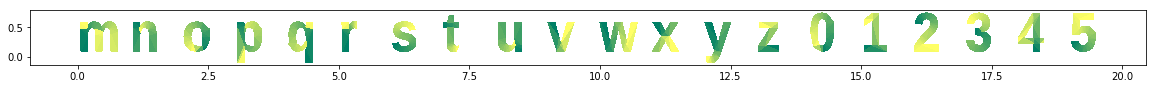

glyph_num (20,)


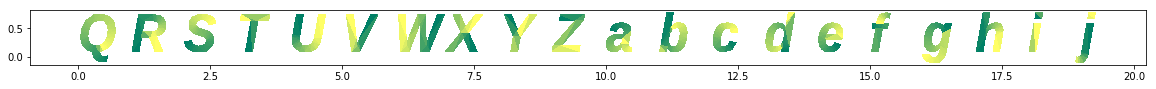

tri_stack (20, 150, 6)


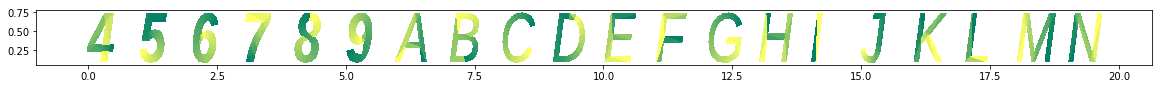

font (20,)


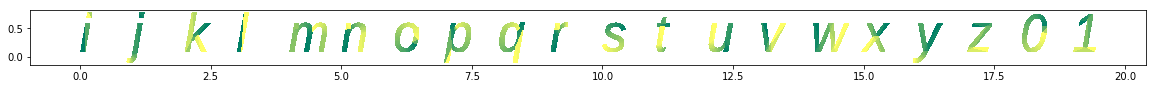

font_num (20,)


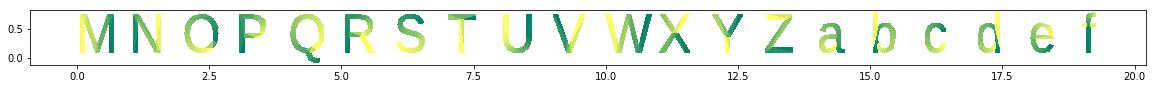

glyph (20,)


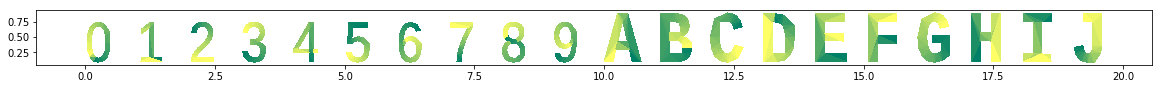

glyph_num (20,)


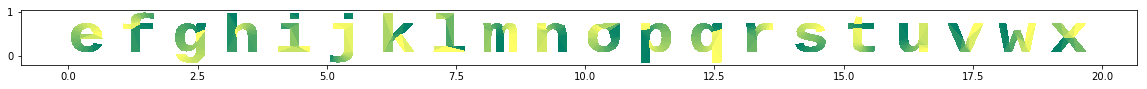

tri_stack (20, 150, 6)


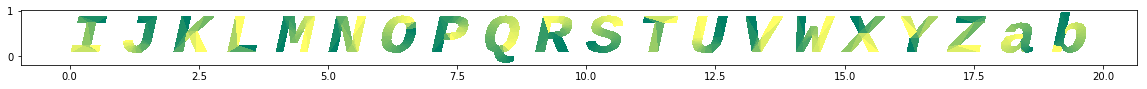

font (20,)


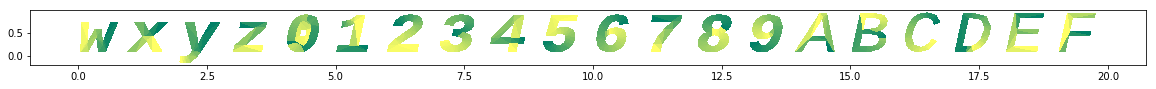

font_num (20,)


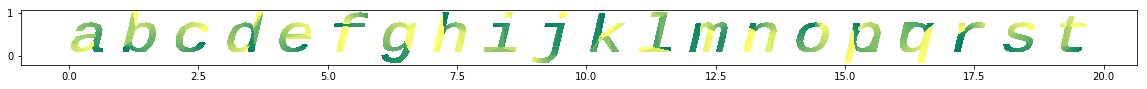

glyph (20,)


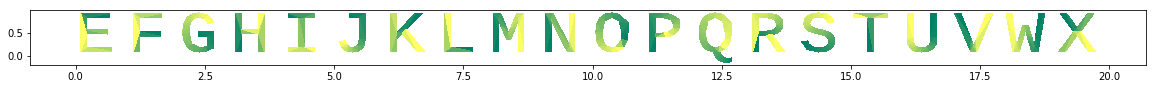

glyph_num (20,)


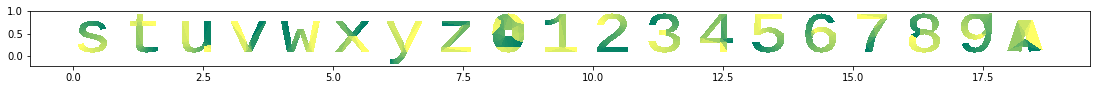

OutOfRangeError: End of sequence
	 [[node IteratorGetNext_2 (defined at <ipython-input-54-217ef714ef32>:28) ]]

Caused by op 'IteratorGetNext_2', defined at:
  File "C:\Users\terry\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\terry\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\terry\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\terry\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\terry\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\terry\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\terry\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\terry\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\terry\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\terry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\terry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\terry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-217ef714ef32>", line 28, in <module>
    next_element = iterator.get_next()
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1711, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\terry\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[node IteratorGetNext_2 (defined at <ipython-input-54-217ef714ef32>:28) ]]


In [54]:
# Test reading

def parse_proto(example_proto):
  features = {
    'glyph_num': tf.FixedLenFeature([], tf.int64),
    'glyph': tf.FixedLenFeature([], tf.string),
    'font_num': tf.FixedLenFeature([], tf.int64),
    'font': tf.FixedLenFeature([], tf.string),
    'tri_stack': tf.FixedLenFeature(ts.TriangleStack.ARRAY_SHAPE, tf.float32),
  }
  data = tf.parse_single_example(example_proto, features)
  #data['tri_stack'] = tf.sparse.add(tf.zeros([MAX_ELEMENTS, 6]), tf.sparse.reshape(data['tri_stack'], [-1, 6]))
  return data

buffer_size=10000
batch_size=20
#dataset = tf.python_io.tf_record_iterator(filename)
dataset = tf.data.TFRecordDataset(filename)
print(dataset.output_types)
print(dataset.output_shapes)
# for d in dataset:
#   print(parse_proto(d))
#dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(parse_proto)
#dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session():
  while True:
    data = dict(next_element)
    for k, v in data.items():
        print(k, v.eval().shape)
        tri_stacks = data['tri_stack'].eval()
        triangles = [ts.TriangleStack.from_array(t).get_triangles() for t in tri_stacks]
        drawTris(np.expand_dims(np.array(triangles), 0))


# Other

[2 2 2 1 4 5 1 2 4 4 1 2 3 3 3 4 4 3 3 3 3 2 2 3 3 3 3 3 3]
[('vertices', 58), ('triangles', 126)]


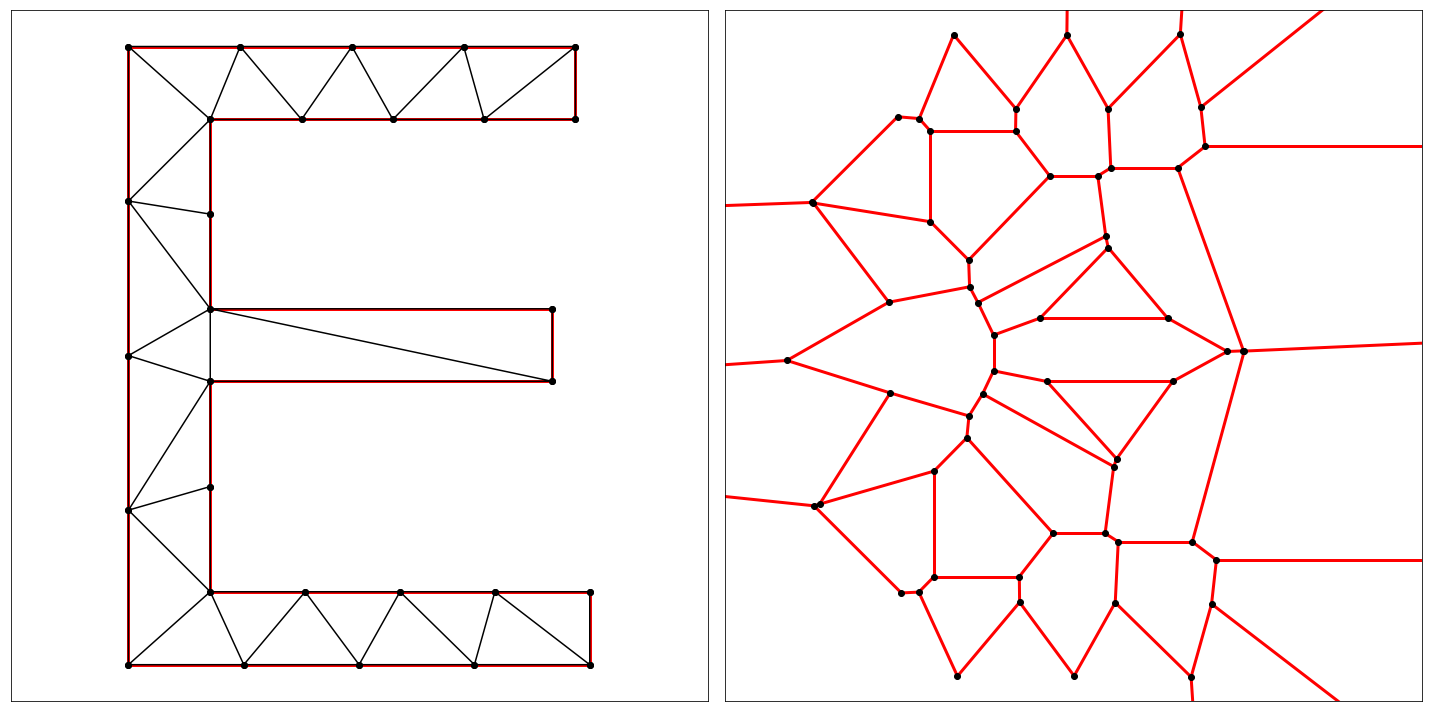

In [0]:
#title Try triangulating or calulcating voronio on just the vertices
glyph = nptris[0,glyphs.index('E')]
#print(glyph)
counts = np.bincount(glyph['triangles'].flatten())
print(counts)
#print(np.bincount(nptris[f,g]['triangles'].flatten()).sum())
T = {
  'vertices': glyph['vertices'],
#  'segments': np.array(segments),
}
#if holes:
#  T['holes'] = np.array(holes).reshape((-1,2))

opts = ''
#opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
#opts = 'q30' # conforming constrained Delaunay triangulation of a PSLG 
#opts = 'D' # conforming Delaunay triangulation 
tris = tr.triangulate(T, opts)
del tris['vertex_markers']
tris['labels']=1
print([(k, v.size) for k,v in tris.items() if isinstance(v, np.ndarray)])
#tr.compare(plt, glyph, tris, figsize=(20,10))
#plt.show()

points, edges, ray_origin, ray_direct = tr.voronoi(glyph['vertices'])
#points2, edges2, ray_origin2, ray_direct2 = tr.voronoi(points)
tr.compare(plt, glyph, {'vertices': points2, 'segments':edges2}, figsize=(20,10))
plt.show()

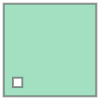

False
True


In [0]:
#title Try debugging shapely contains()
g1=shapely.geometry.LinearRing([(0, 0), (10, 0), (10, 10), (0,10)])
g2=shapely.geometry.LinearRing([(1,1),(2,1),(2,2),(1,2)])
display(shapely.geometry.Polygon(g1, [g2]))
print(g2.within(g1))  # ==False: see https://github.com/Toblerity/Shapely/issues/275
print(shapely.geometry.Polygon(g2).within(shapely.geometry.Polygon(g1))) # ==True

[(array([ 0.2 , -0.79]), array([ 0.2 , -0.78])), (array([ 0.2 , -0.78]), array([ 0.22, -0.77])), (array([ 0.22, -0.77]), array([ 0.25, -0.76])), (array([ 0.25, -0.76]), array([ 0.28, -0.7 ])), (array([ 0.28, -0.7 ]), array([ 0.49, -0.21])), (array([ 0.49, -0.21]), array([ 0.5 , -0.21])), (array([ 0.5 , -0.21]), array([ 0.74, -0.74])), (array([ 0.74, -0.74]), array([ 0.76, -0.76])), (array([ 0.76, -0.76]), array([ 0.77, -0.77])), (array([ 0.77, -0.77]), array([ 0.8 , -0.78])), (array([ 0.8 , -0.78]), array([ 0.8 , -0.79])), (array([ 0.8 , -0.79]), array([ 0.58, -0.79])), (array([ 0.58, -0.79]), array([ 0.58, -0.78])), (array([ 0.58, -0.78]), array([ 0.62, -0.77])), (array([ 0.62, -0.77]), array([ 0.63, -0.76])), (array([ 0.63, -0.76]), array([ 0.64, -0.74])), (array([ 0.64, -0.74]), array([ 0.62, -0.68])), (array([ 0.62, -0.68]), array([ 0.59, -0.6 ])), (array([ 0.59, -0.6 ]), array([ 0.36, -0.6 ])), (array([ 0.36, -0.6 ]), array([ 0.32, -0.71])), (array([ 0.32, -0.71]), array([ 0.31, -

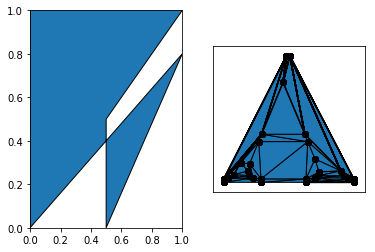

In [0]:
#title Try using shapely triangulate (but it doesn't support holes)
#points = shapely.geometry.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
A = tr.get_data('A')
print([(A["vertices"][s], A["vertices"][e]) for s,e in A["segments"]])
points = shapely.geometry.MultiPoint([A["vertices"][s] for s,e in A["segments"]])
triangles = shapely.ops.triangulate(points)
print([triangle.wkt for triangle in triangles])

ax1 = plt.subplot(122)
tr.plot(ax1,
        vertices=[p for poly in triangles for p in poly.exterior.coords],
        triangles=[(i, i+1, i+2) for i in range(len(triangles))]
       )
for poly in triangles:
  ax1.add_patch(descartes.PolygonPatch(poly))
# plt.show()

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = shapely.geometry.Polygon([(0, 0), (0, 1.8), (1, 1), (.5, .5), (.5, 0), (1, 0.8), (0, 0)])
#ax = fig.add_subplot(111)
ax = plt.subplot(121)
ax.add_patch(descartes.PolygonPatch(ring_mixed))

plt.show()

dict_keys(['vertices', 'segments', 'holes'])


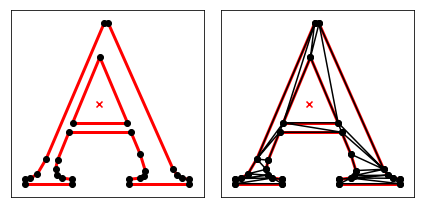

In [126]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
del A['vertex_attributes']
print(A.keys())
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
# #plt.figure()
# ax1 = plt.subplot(121)
# tr.plot(ax1, **A)
# lim = ax1.axis()
# ax2 = plt.subplot(122, sharey=ax1)
# tr.plot(ax2, **B)
# ax2.axis(lim)
# plt.tight_layout()
plt.show()

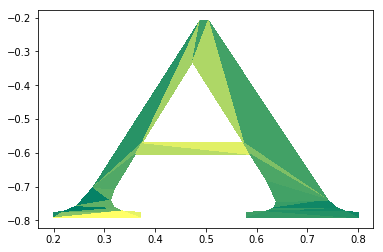

In [148]:
A = tr.get_data('A')
TA = tr.triangulate(A, opts='p')
tri = matplotlib.tri.Triangulation(TA["vertices"][:,0], TA["vertices"][:,1], TA["triangles"])
plt.tripcolor(tri, np.array(range(len(TA["triangles"])))/len(TA["triangles"]), cmap=plt.summer())
plt.show()